# Cox-Time

In this notebook we will train the [Cox-Time method](http://jmlr.org/papers/volume20/18-424/18-424.pdf).
We will use the METABRIC data sets as an example

A more detailed introduction to the `pycox` package can be found in [this notebook](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb) about the `LogisticHazard` method.

The main benefit Cox-Time (and the other Cox methods) has over Logistic-Hazard is that it is a continuous-time method, meaning we do not need to discretize the time scale.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxTime
from pycox.models.cox_time import MLPVanillaCoxTime
from pycox.evaluation import EvalSurv

In [2]:
## Uncomment to install `sklearn-pandas`
# ! pip install sklearn-pandas

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset

We load the METABRIC data set and split in train, test and validation.

In [3]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [4]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0


## Feature transforms
We have 9 covariates, in addition to the durations and event indicators.

We will standardize the 5 numerical covariates, and leave the binary variables as is. As variables needs to be of type `'float32'`, as this is required by pytorch.

In [5]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [6]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

The targets (durations and events) also needs to be arrays of type `'float32'`, and with the `CoxTime.label_transform` we standardize the durations.

In [7]:
labtrans = CoxTime.label_transform()
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
durations_test, events_test = get_target(df_test)
val = tt.tuplefy(x_val, y_val)

In [8]:
val.shapes()

((305, 9), ((305,), (305,)))

With `TupleTree` (the results of `tt.tuplefy`) we can easily repeat the validation dataset multiple times. This will be useful for reduce the variance of the validation loss, as the validation loss of `CoxTime` is not deterministic.

In [9]:
val.repeat(2).cat().shapes()

((610, 9), ((610,), (610,)))

## Neural net

We create a simple MLP with two hidden layers, ReLU activations, batch norm and dropout. 
The net required by `CoxTime` is slightly different than most of the other methods as it also take `time` and an additional input argument. 
We have therefore crated the `MLPVanillaCoxTime` class that is a suitable version of `tt.practical.MLPVanilla`.
This class also removes the options for setting `out_features` and `output_bias` as they should be `1` and `False`, respectively.

To see the code for the networks call `??MLPVanillaCoxTime`.

In [10]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
batch_norm = True
dropout = 0.1
net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)

## Training the model

To train the model we need to define an optimizer. You can choose any `torch.optim` optimizer, but here we instead use one from `tt.optim` as it has some added functionality.
We use the `Adam` optimizer, but instead of choosing a learning rate, we will use the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate with `model.lr_finder`. See [this post](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for an explanation.

We also set `labtrans` which connects the output nodes of the network the the label transform of the durations. This is only useful for prediction and does not affect the training procedure.

In [11]:
model = CoxTime(net, tt.optim.Adam, labtrans=labtrans)

/rds/user/sb2690/hpc-work/software/micromamba/envs/shares3/lib/python3.9/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_s

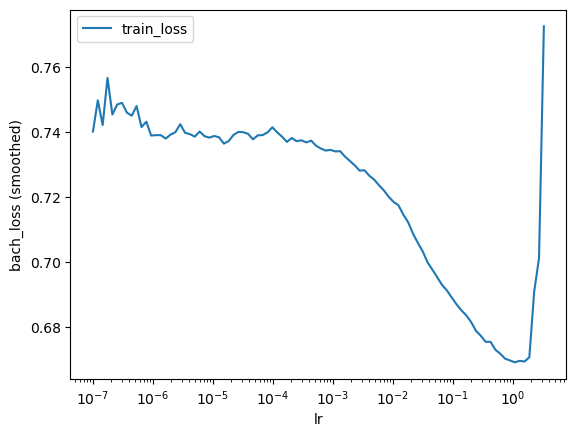

In [12]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=2)
_ = lrfinder.plot()

In [13]:
lrfinder.get_best_lr()

np.float64(0.10722672220103299)

Often, this learning rate is a little high, so we instead set it manually to 0.01

In [14]:
model.optimizer.set_lr(0.01)

We include the `EarlyStopping` callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [18]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [19]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val.repeat(10).cat())

23:	[0s / 0s],		train_loss: 0.5827,	val_loss: 0.5863
24:	[0s / 0s],		train_loss: 0.5852,	val_loss: 0.5916
25:	[0s / 0s],		train_loss: 0.5831,	val_loss: 0.5887
26:	[0s / 0s],		train_loss: 0.5925,	val_loss: 0.5822
27:	[0s / 0s],		train_loss: 0.5890,	val_loss: 0.5910
28:	[0s / 0s],		train_loss: 0.5932,	val_loss: 0.5919
29:	[0s / 0s],		train_loss: 0.5522,	val_loss: 0.5989
30:	[0s / 0s],		train_loss: 0.5858,	val_loss: 0.6067
31:	[0s / 0s],		train_loss: 0.5743,	val_loss: 0.5908
32:	[0s / 0s],		train_loss: 0.5635,	val_loss: 0.5806
33:	[0s / 0s],		train_loss: 0.5581,	val_loss: 0.5950
34:	[0s / 0s],		train_loss: 0.5726,	val_loss: 0.6310
35:	[0s / 0s],		train_loss: 0.5544,	val_loss: 0.6048
36:	[0s / 0s],		train_loss: 0.5514,	val_loss: 0.6048
37:	[0s / 0s],		train_loss: 0.5705,	val_loss: 0.6016
38:	[0s / 0s],		train_loss: 0.5356,	val_loss: 0.5989
39:	[0s / 0s],		train_loss: 0.5594,	val_loss: 0.6058
40:	[0s / 0s],		train_loss: 0.5676,	val_loss: 0.6027
41:	[0s / 0s],		train_loss: 0.5675,	val_loss: 

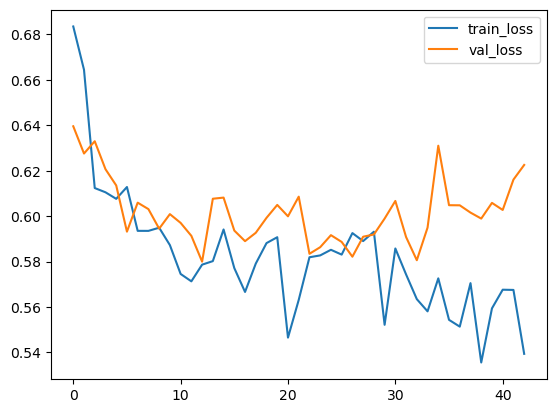

In [20]:
_ = log.plot()

We can get the partial log-likelihood

In [60]:
input, target = model.training_data 
df = model.target_to_df(target)
input = tt.tuplefy(input).to_numpy().iloc[df.index.values]

def compute_expg_at_risk(ix, t):
    sub = input.iloc[ix:]
    n = sub.lens().flatten().get_if_all_equal()
    t = np.repeat(t, n).reshape(-1, 1).astype('float32')
    return np.exp(model.predict((sub, t), batch_size, True, True)).flatten().sum()

times = (df                                     # SBL: This is just the array of uncensored event times with corresponding X_train index
    .loc[lambda x: x['event'] != 0]
    ['duration']
    .loc[lambda x: x <= np.inf]
    .drop_duplicates(keep='first')
)

at_risk_sum = (pd.Series([compute_expg_at_risk(ix, t) for ix, t in times.items()], # Call compute_expg_at_risk for each uncensored sample's X and T
                            index=times.values)
                .rename('at_risk_sum'))

In [74]:
np.exp(model.predict((sub, t), batch_size, True, True)).flatten()

array([3.4574616 , 1.2232772 , 2.4452457 , ..., 1.6464981 , 0.60732335,
       0.80821526], dtype=float32)

In [68]:
sub = input.iloc[5:]
n = sub.lens().flatten().get_if_all_equal()
t = np.repeat(times.iloc[5], n).reshape(-1, 1).astype('float32')

In [21]:
model.partial_log_likelihood(*val).mean()

np.float32(-4.8769817)

## Prediction

For evaluation we first need to obtain survival estimates for the test set.
This can be done with `model.predict_surv` which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

However, as Cox-Time is semi-parametric, we first need to get the non-parametric baseline hazard estimates with `compute_baseline_hazards`. 

Note that for large datasets the `sample` argument can be used to estimate the baseline hazard on a subset.

In [86]:
np.hstack((sub[0],t))

array([[ 0.44108987, -1.008773  ,  1.8892177 , ...,  0.        ,
         0.        , -1.5254941 ],
       [-1.0140232 , -0.9020607 , -0.22051755, ...,  0.        ,
         1.        , -1.5254941 ],
       [ 0.09552006, -0.5841231 , -0.41422173, ...,  0.        ,
         1.        , -1.5254941 ],
       ...,
       [-0.13262896,  0.8665437 , -0.20021665, ...,  0.        ,
         1.        , -1.5254941 ],
       [-0.8037041 ,  1.351695  ,  1.1059334 , ...,  0.        ,
         1.        , -1.5254941 ],
       [-0.91354597, -0.39343384, -0.40095046, ...,  0.        ,
         1.        , -1.5254941 ]], dtype=float32)

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
from lifelines.utils import concordance_index
class SymRegCT(BaseEstimator, RegressorMixin, CoxTime):
    """
    Wrapper for gplearn's SymbolicRegressor to use with pycox supporting functions
    """

    def __init__(self, model):
        self.model = model

    def fit(self, X, T, E, *args, **kwargs): 
        Xt = np.hstack((X, T))
        self.model.fit(Xt, sample_weight=E)
        self.training_data = tt.tuplefy(X, (T, E))
        return self

    def predict(self, X, t, *args, **kwargs):
        if isinstance(X, tt.TupleTree):
            X = X[0]
        Xt = np.hstack((X, t)) # Simply add the time as another column to the input just like MLPVanillaCoxTime
        return self.model.predict(Xt)

    def score(self, X, t, y, sample_weight, *args, **kwargs):
        y_pred = self.predict(X, t)
        return concordance_index(y, y_pred, sample_weight)

    def silent(self):
        return self.model.set_params(verbose=False)

In [102]:
m2 = SymRegCT(model) 
m2.training_data = tt.tuplefy(X, (T, E))
m2.compute_baseline_hazards()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [22]:
_ = model.compute_baseline_hazards()

In [23]:
surv = model.predict_surv_df(x_test)

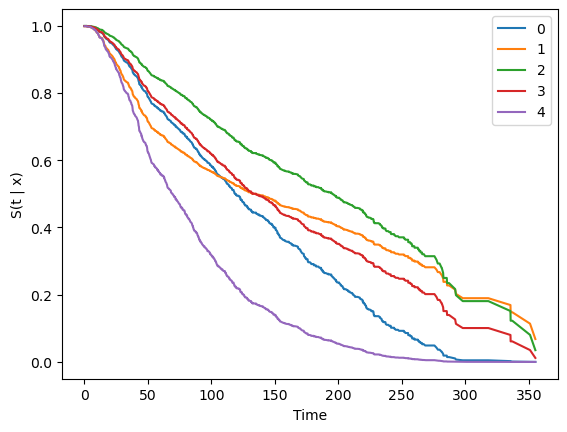

In [24]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

Note that because we set `labtrans` in `CoxTime` we get the correct time scale for our predictions.

## Evaluation

We can use the `EvalSurv` class for evaluation the concordance, brier score and binomial log-likelihood. Setting `censor_surv='km'` means that we estimate the censoring distribution by Kaplan-Meier on the test set.

In [25]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [26]:
ev.concordance_td()

0.6690964570266147

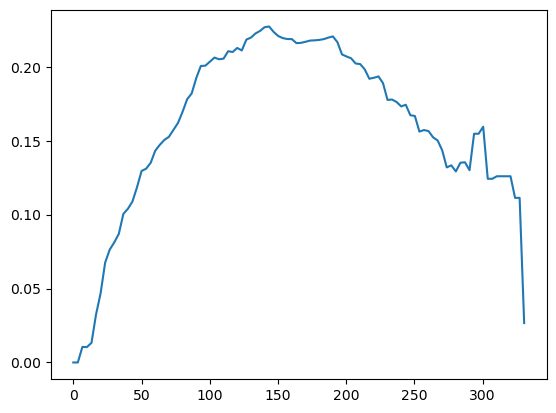

In [27]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [28]:
ev.integrated_brier_score(time_grid)

np.float64(0.16105769775756484)

In [29]:
ev.integrated_nbll(time_grid)

np.float64(0.47530716504388004)